In [ ]:
from prov.model import *

In [2]:
from prov.graph import prov_to_graph, graph_to_prov

In [3]:
import networkx as nx

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [22]:
# file_path = "/home/koehler/PycharmProjects/alpaca/examples/run_basic.ttl"
file_path = "/home/koehler/outputs/provenance/psd_by_trial_type/R2G_PSD_all_subjects.ttl"

In [23]:
doc = ProvDocument.deserialize(file_path, format="rdf")

In [24]:
def _filter_and_reverse(graph):
    filter_nodes = [node for node in graph.nodes if not isinstance(node, (ProvEntity, ProvActivity))]
    graph.remove_nodes_from(filter_nodes)

    filter_edges = [edge for *edge, data in graph.edges(data=True) if not isinstance(data['relation'], (ProvMembership, ProvUsage, ProvGeneration))]
    graph.remove_edges_from(filter_edges)
    return graph.reverse(copy=True)

In [25]:
g = prov_to_graph(doc)

In [ ]:
raw_prov = _filter_and_reverse(g)

In [10]:
NID_ALPACA = "alpaca"

NSS_FUNCTION = "function"             # Functions executed
NSS_FILE = "file"                     # Files accessed
NSS_DATA = "object"                   # Data objects (input/outputs/containers)
NSS_SCRIPT = "script"                 # The execution script

NSS_PARAMETER = "parameter"           # Function parameter
NSS_ATTRIBUTE = "attribute"           # Data object attribute (i.e., class)
NSS_ANNOTATION = "annotation"         # Data object annotation (e.g., Neo)
NSS_CONTAINER = "container"           # For storing container membership access information


ALL_NSS = [NSS_FUNCTION, NSS_FILE, NSS_DATA, NSS_SCRIPT, NSS_PARAMETER,
           NSS_ATTRIBUTE, NSS_ANNOTATION, NSS_CONTAINER]

NAMESPACES = [Namespace(namespace, f"urn:{NID_ALPACA}:{namespace}:")
              for namespace in ALL_NSS]


In [11]:
def _find_namespace(uri):
    for ns in NAMESPACES:
        parts = uri.split(ns.uri)
        if len(parts) > 1:
            return ns.prefix, parts[1]
    return None

In [12]:
_find_namespace("urn:alpaca:file:sha256:xxxxxx")

('file', 'sha256:xxxxxx')

In [13]:
def _get_id(uri):
    node_id = str(uri)
    namespace = _find_namespace(node_id)
    if namespace:
        return ":".join(namespace)
    return node_id


def _get_data(node, node_id, annotations=None, attributes=None, strip_namespace=True):
    filter_map = defaultdict(list)
    filter_map.update({NSS_ANNOTATION: annotations, NSS_ATTRIBUTE: attributes})
    
    data = {"gephi_interval": []}
    namespace, local_part = node_id.split(":", 1)
    data['type'] = "activity" if namespace == NSS_FUNCTION else namespace

    info = local_part.split(":")
    data['data_hash'] = info[-1]
    if namespace == NSS_FILE:
        data['label'] = "File"
        data['hash_type'] = info[-2]
    elif namespace == NSS_DATA:
        data['label'] = info[-2].split(".")[-1]
        data['Python_name'] = info[-2]
    
    for attr in node.attributes:
        attr_type = str(attr[0].namespace.prefix)
        attr_name = attr[0].localpart
        attr_value = attr[1]
           
        if annotations or attributes:
             if attr_name in filter_map[attr_type]:
                if not strip_namespace:
                    attr_name = f"{attr_type}:{attr_name}"
                if attr_name in data:
                    raise ValueError("Duplicate property values. Make sure to include the namespaces!")
                data[attr_name] = attr_value
                
        if namespace == NSS_FILE and attr_type in ("rdfs", "prov") and attr_name == "label":
            data["File_path"] = attr_value
            
    return data
    
    
def _add_gephi_interval(data, order):
    if not "gephi_interval" in data:
        data["gephi_interval"] = []
    data["gephi_interval"].append((order, order))
    

def _get_function_call_node(u_id, v_id, relation):
    node_id = v_id if isinstance(relation, ProvUsage) else u_id
    
    data = {}
    for attr in relation.attributes:
        attr_type = str(attr[0].namespace.prefix)
        attr_name = attr[0].localpart
        attr_value = attr[1]

        if attr_type == "prov" and attr_name == "value":
            data["execution_order"] = attr_value
        elif attr_type == NSS_PARAMETER:
            data[f"{attr_type}:{attr_name}"] = attr_value

    _add_gephi_interval(data, data["execution_order"])
            
    data["type"] = NSS_FUNCTION
    data["Python_name"] = node_id.split(":")[-1]
    data["label"] = data["Python_name"].split(".")[-1]
    node_hash = hash((node_id, data["execution_order"]))
    return node_hash, data
    

def _get_membership_relation(relation, graph):
    # Retrieve the relevant parameter (index/slice, attribute)
    # The entity that is inside the collection has an attribute
    # with the namespace `container:`, with the index/slice or
    # attribute name information

    member = None
    for attr in relation.attributes:
        if str(attr[0]) == "prov:entity":
            member = attr[1].uri
    
    for node in graph.nodes:
        if node.identifier.uri == member:
            # ProvEntity object of the collection's member
            for attr in node.attributes:
                container_attribute = str(attr[0])
                if container_attribute.startswith(f"{NSS_CONTAINER}:"):
                    # This is the membership ProvEntity attribute
                    # Get the attribute name or index/slice value
                    member_type = container_attribute.split(":")[-1]
                    if member_type == "attribute":
                        return f".{attr[1]}"
                    else:
                        return f"[{attr[1]}]"
    
def _transform_graph(graph, annotations=None, attributes=None, strip_namespace=True):
    # Transform a NetworkX graph obtained from the PROV data, so that the visualization
    # is simplified. A new `nx.DiGraph` object is created and returned
    # Annotations and attributes of the entities stored in the PROV file can be filtered
    
    transformed = nx.DiGraph()
    
    # Copy all the nodes, changing the URI to string and extracting the requested attributes/annotations as node data
    for node in graph.nodes:
        node_id = _get_id(node.identifier.uri)
        data = _get_data(node, node_id, annotations=annotations, attributes=attributes, strip_namespace=strip_namespace)
        transformed.add_node(node_id, **data)
        
    # Add all the edges
    # If membership, the direction must be reversed
    # If usage/generation, create additional nodes for the function call, with the parameters as node data
    # A membership flag is created, as this will be used
    for u, v, data in graph.edges(data=True):
        u_id = _get_id(u.identifier.uri)
        v_id = _get_id(v.identifier.uri)
        
        relation = data['relation']
        if isinstance(relation, ProvMembership):
            membership_relation = _get_membership_relation(relation, graph)
            transformed.add_edge(v_id, u_id, membership=True, membership_relation=membership_relation)
        elif isinstance(relation, (ProvUsage, ProvGeneration)):    
            node_id, node_data = _get_function_call_node(u_id, v_id, relation)
            if not node_id in graph.nodes:
                transformed.add_node(node_id, **node_data)

            if isinstance(relation, ProvUsage):
                transformed.add_edge(u_id, node_id, membership=False)
                _add_gephi_interval(transformed.nodes[u_id], node_data['execution_order'])
            else:
                transformed.add_edge(node_id, v_id, membership=False)
                _add_gephi_interval(transformed.nodes[v_id], node_data['execution_order'])
        
    # Remove old ProvActivity nodes that are not needed anymore (unconnected)
    # They were set with the `type` as `activity` in the node data dictionary
    filter_nodes = [node for node, data in transformed.nodes(data=True) if data['type'] == "activity"]
    transformed.remove_nodes_from(filter_nodes)
   
    return transformed

In [14]:
def _find_missing_intervals(graph, node=None):
    # Find all membership nodes and create a subgraph with the ancestors and successors
    # We will have all the spots where the execution counter was not set
    # Then we build, for each path from the bottom to the top, the full list with intervals at each node
    processed_nodes = []
    subgraph_nodes = []
    for u, v, data in graph.edges(data=True):
        if data['membership']:
            subgraph_nodes.extend([u, v])
            
    subgraph = graph.subgraph(subgraph_nodes).reverse(copy=True)
    
    # We do progressively, changing the successors of the root nodes
    # each time, and generating a new subgraph until no nodes remain
    while not nx.is_empty(subgraph):
        root_nodes = [node for node in subgraph.nodes if subgraph.in_degree(node) == 0]
        for root in root_nodes:
            successors = subgraph.successors(root)
            interval = subgraph.nodes[root]["gephi_interval"]
            for succ in successors:
                graph.nodes[succ]["gephi_interval"].extend(interval)

        processed_nodes.extend(root_nodes)
        subgraph_nodes = []
        for u, v, data in graph.edges(data=True):
            if data['membership'] and v not in processed_nodes:
                subgraph_nodes.extend([u, v])
            
        subgraph = graph.subgraph(subgraph_nodes).reverse(copy=True)
            

def _generate_interval_strings(graph):
    for node, data in graph.nodes(data=True):
        data["gephi_interval"].sort(key=lambda tup: tup[0])
        segments = ";".join([f"[{start:.1f},{stop:.1f}]" for start, stop in data["gephi_interval"]])
        interval = f"<{segments}>"
        data["Time Interval"] = interval
        data.pop("gephi_interval")

In [15]:
prov_graph = _transform_graph(raw_prov, attributes=('dtype', 'shape', 'name', 'units', 'name', 'description', 'file_origin', 't_start', 't_stop'), annotations=('subject_name', 'channel_names'), strip_namespace=True)
_find_missing_intervals(prov_graph)
_generate_interval_strings(prov_graph)

In [16]:
for n, data in prov_graph.nodes(data=True):
    print(n, data)

object:neo.core.block.Block:0253b291f2ebbe486806446673c3039f57020bd0 {'type': 'object', 'data_hash': '0253b291f2ebbe486806446673c3039f57020bd0', 'label': 'Block', 'Python_name': 'neo.core.block.Block', 'description': 'Block of reach-to-grasp project data from Blackrock file set.', 'name': 'Reachgrasp Recording Data Block', 'file_origin': '/home/koehler/datafiles/multielectrode_grasp/datasets/i140703-001', 'subject_name': "['monkey_N']", 'Time Interval': '<[1.0,1.0];[2.0,2.0];[3.0,3.0];[4.0,4.0]>'}
object:numpy.float64:eb499820c46fbcedfafd8957c169073b13b52ac4 {'type': 'object', 'data_hash': 'eb499820c46fbcedfafd8957c169073b13b52ac4', 'label': 'float64', 'Python_name': 'numpy.float64', 'shape': '()', 'dtype': 'float64', 'Time Interval': '<[7.0,7.0]>'}
object:numpy.ndarray:1547598c7eaddc0bb9926f0d38483280953de19d {'type': 'object', 'data_hash': '1547598c7eaddc0bb9926f0d38483280953de19d', 'label': 'ndarray', 'Python_name': 'numpy.ndarray', 'shape': '(5,)', 'dtype': 'float64', 'Time Interva

In [17]:
for *e, data in prov_graph.edges(data=True):
    print(e, data)

['object:neo.core.block.Block:0253b291f2ebbe486806446673c3039f57020bd0', 'object:builtins.list:1412b16ccbcac9d2ac2b7ee0e6cbe84edc2bd312'] {'membership': True, 'membership_relation': '.segments'}
['object:builtins.list:1412b16ccbcac9d2ac2b7ee0e6cbe84edc2bd312', 'object:neo.core.segment.Segment:7be4d879e98f6ad829c5701d0353c7990bbedbe1'] {'membership': True, 'membership_relation': '[0]'}
['object:builtins.list:c2aaec810a4e8fff49247be8b7ac72d88b4c0de4', 'object:neo.core.spiketrain.SpikeTrain:39a2dcca0582d4721cbc4f0fe9ff786a790da987'] {'membership': True, 'membership_relation': '[1]'}
['object:builtins.list:c2aaec810a4e8fff49247be8b7ac72d88b4c0de4', 'object:neo.core.spiketrain.SpikeTrain:8a10b819cf850f7942c514ee06f0bc37e9309040'] {'membership': True, 'membership_relation': '[0]'}
['object:neo.core.segment.Segment:7be4d879e98f6ad829c5701d0353c7990bbedbe1', 'object:builtins.list:c2aaec810a4e8fff49247be8b7ac72d88b4c0de4'] {'membership': True, 'membership_relation': '.spiketrains'}
['file:sha25

In [18]:
nx.write_graphml(prov_graph, "/home/koehler/Desktop/teste.graphml")
nx.write_gexf(prov_graph, "/home/koehler/Desktop/teste.gexf")

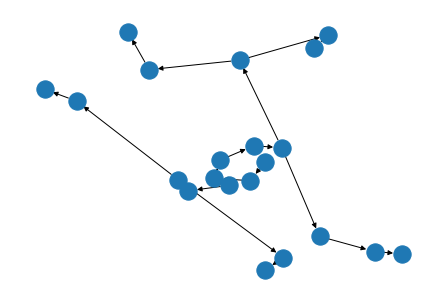

In [19]:
nx.draw(prov_graph)

In [20]:
C5 = nx.cycle_graph(5)
C4 = nx.cycle_graph(4)
M = nx.contracted_edge(C5, (0, 1), self_loops=False)
nx.is_isomorphic(M, C4)

True

In [21]:
for node in M.nodes:
    print(node)

0
2
3
4
